[INFO] Using device: cuda

=== Running experiment 1/20 ===
[INFO] rep 0 saved: ./reps_sim_dat/x_rep0.csv, ./reps_sim_dat/y_rep0.csv

[INFO] Penalty 0.01

[INFO] Penalty 0.1

[INFO] Penalty 0.5

[INFO] Penalty 1

[INFO] Penalty 10

[INFO] Penalty 100
[INFO] Best penalty=1

[INFO] Penalty 1

=== Running experiment 2/20 ===
[INFO] rep 1 saved: ./reps_sim_dat/x_rep1.csv, ./reps_sim_dat/y_rep1.csv

[INFO] Penalty 0.01

[INFO] Penalty 0.1

[INFO] Penalty 0.5

[INFO] Penalty 1

[INFO] Penalty 10

[INFO] Penalty 100
[INFO] Best penalty=0.1

[INFO] Penalty 0.1

=== Running experiment 3/20 ===
[INFO] rep 2 saved: ./reps_sim_dat/x_rep2.csv, ./reps_sim_dat/y_rep2.csv

[INFO] Penalty 0.01

[INFO] Penalty 0.1

[INFO] Penalty 0.5

[INFO] Penalty 1

[INFO] Penalty 10

[INFO] Penalty 100
[INFO] Best penalty=0.1

[INFO] Penalty 0.1

=== Running experiment 4/20 ===
[INFO] rep 3 saved: ./reps_sim_dat/x_rep3.csv, ./reps_sim_dat/y_rep3.csv

[INFO] Penalty 0.01

[INFO] Penalty 0.1

[INFO] Penalty 0.5

[INFO]

KeyboardInterrupt: 

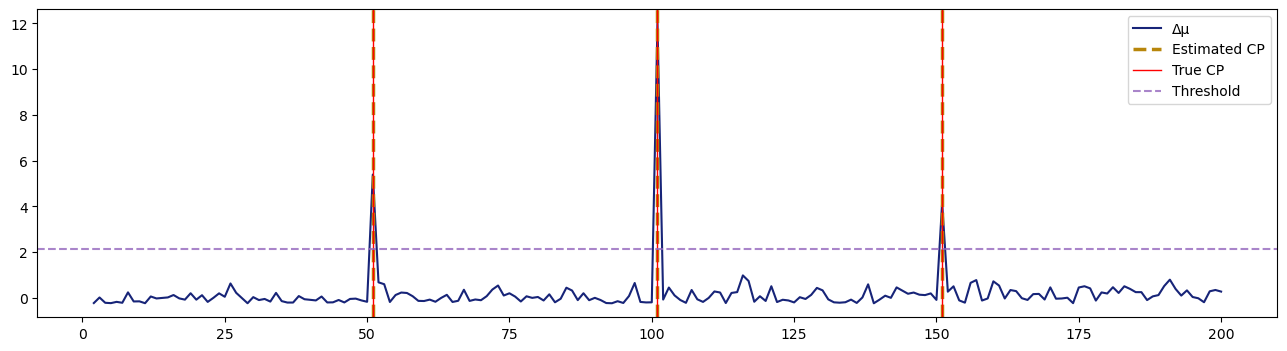

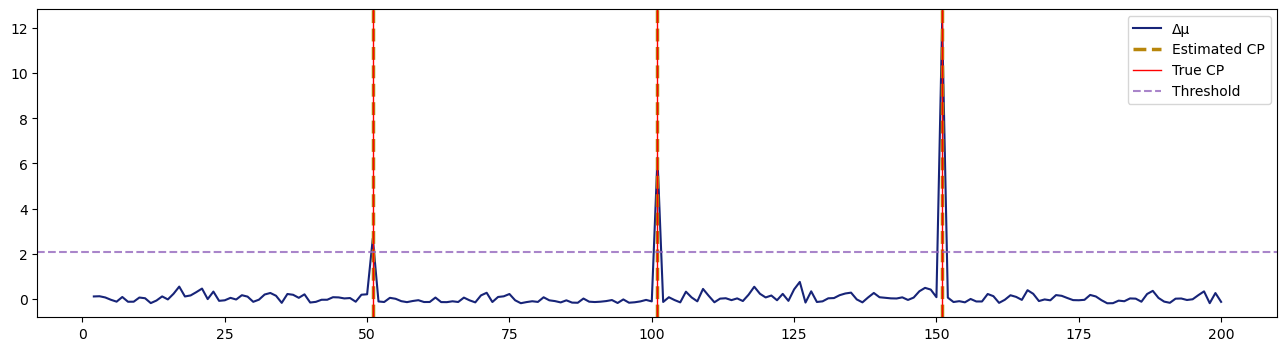

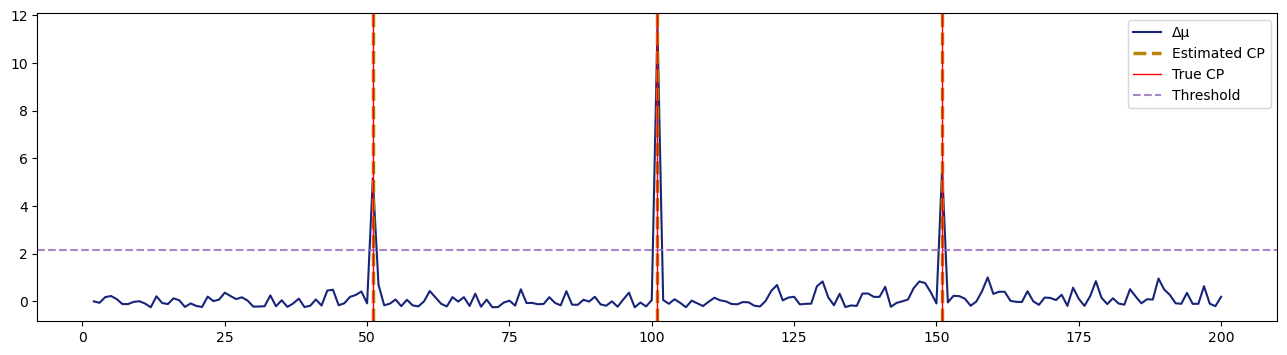

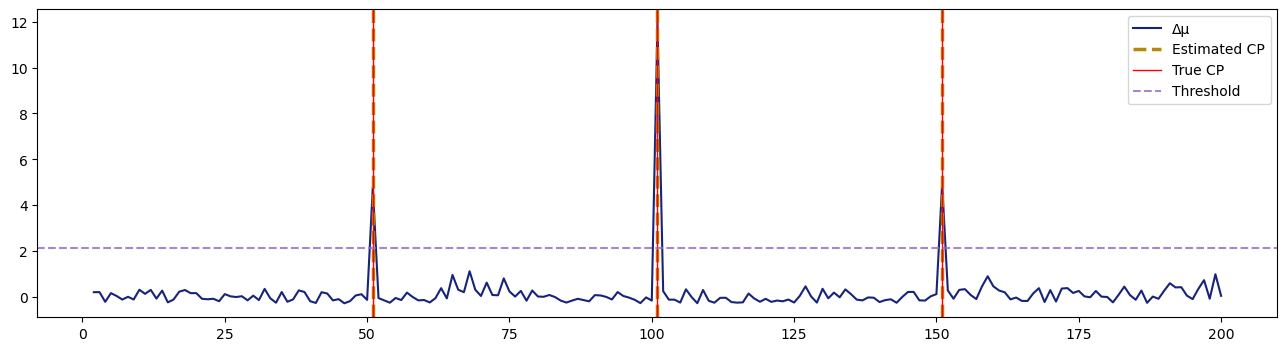

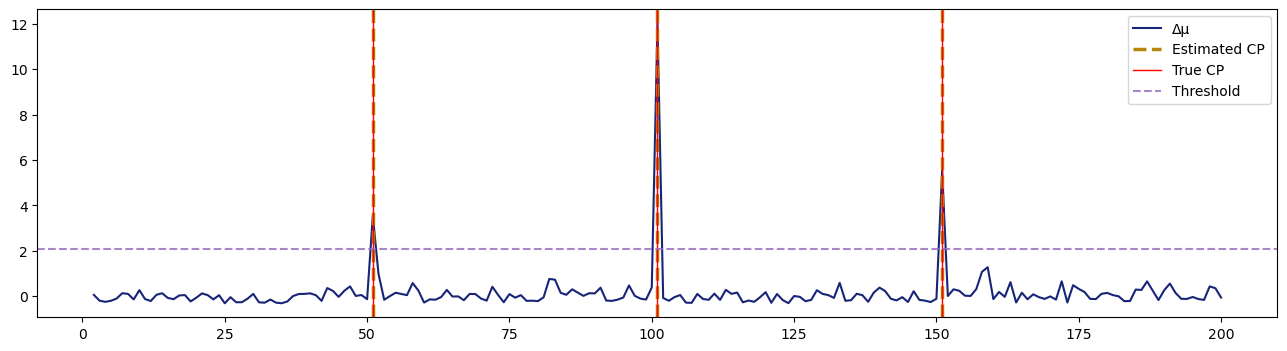

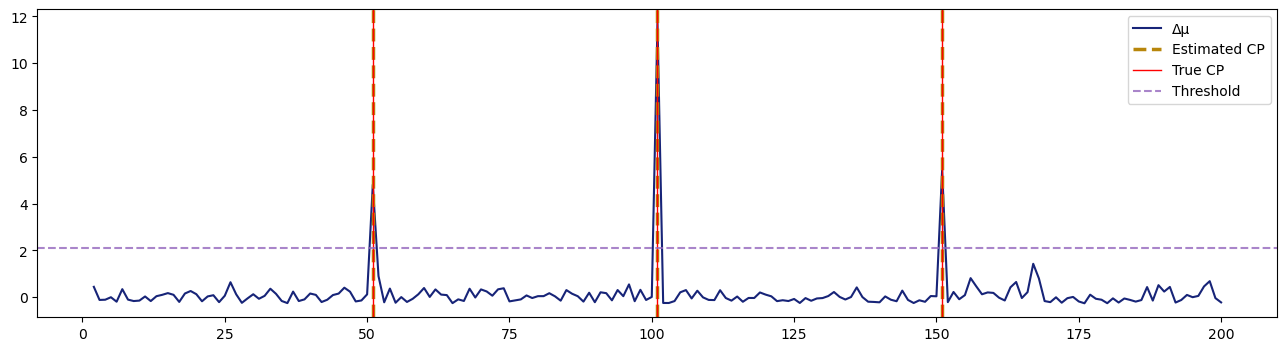

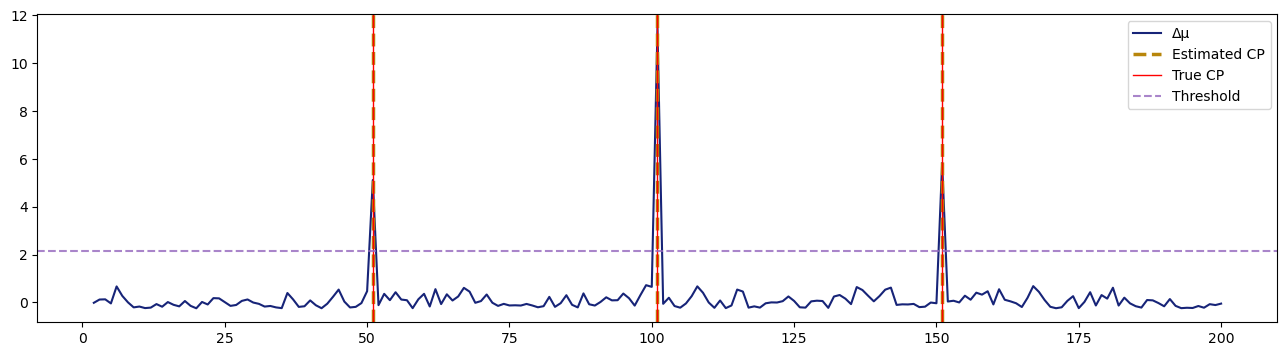

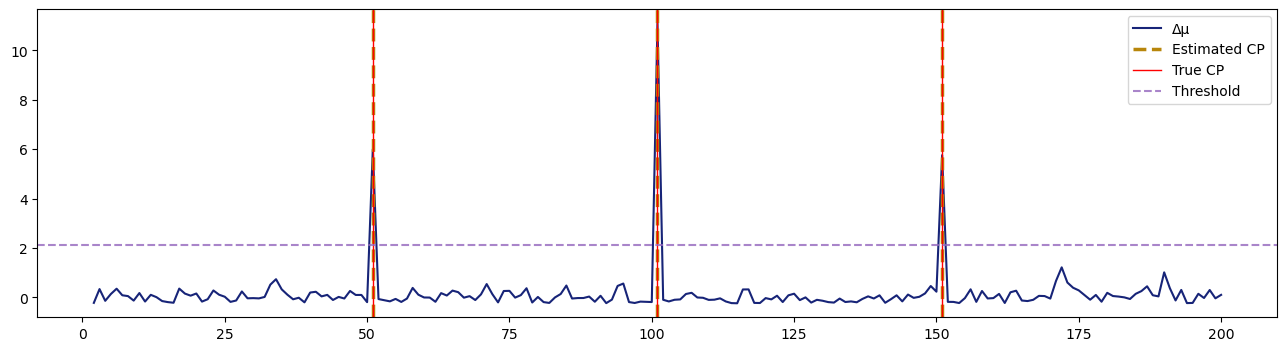

In [8]:
import torch
import numpy as np
import pandas as pd
from cpd_model import parse_args, learn_one_seq_penalty
from simulation_data_3cp import generate_x, generate_data, mean_func, sigma_func

def run_multiple_experiments(n_repeats=20, save_path="./exp_results.pkl"):
    save_dir = "./reps_sim_dat"
    args = parse_args()
    """
    Choose parameters in args
    parser.add_argument('--z_dim', default=1, type=int) 
    parser.add_argument('--x_dim', default=3, type=int) 
    parser.add_argument('--y_dim', default=3, type=int)
    parser.add_argument('--K_dim', default=3, type=int)
    parser.add_argument('--output_layer', nargs='+', type=int, default=[128,128]) 
    parser.add_argument('--num_samples', default=100, type=int) 
    parser.add_argument('--num_time', default=200, type=int)
    parser.add_argument('--penalties', nargs='+', type=float, default=[0.01,0.1,0.5,1,10,100])
    parser.add_argument('--epoch', default=20, type=int)
    parser.add_argument('--decoder_lr', default=0.01, type=float)
    parser.add_argument('--langevin_K', default=100, type=int)
    parser.add_argument('--langevin_s', default=0.1, type=float)
    parser.add_argument('--kappa', default=0.1, type=float)
    parser.add_argument('--nu_iteration', default=20, type=int)
    parser.add_argument('--decoder_iteration', default=20, type=int)
    parser.add_argument('--loss_thr', default=1e-5, type=float)
    parser.add_argument('--iter_thr', default=5, type=int)
    parser.add_argument('--true_CP_full', nargs='+', type=int, default=[51,101,151])
    parser.add_argument('--signif_level', default=0.975, type=float)
    args, _ = parser.parse_known_args()
    """
    args.epoch = 30
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print("[INFO] Using device:", device)

    all_results = []

    for rep in range(n_repeats):
        print(f"\n=== Running experiment {rep+1}/{n_repeats} ===")
        np.random.seed(rep)

        X = generate_x(args.num_time, args.num_samples, args.x_dim)
        X_out, Y_out, Z_out = generate_data(
            X, mean_func, sigma_func,
            change_points=[50, 100, 150],
            z_means=[0, 1, -1, -2]
        )

        import pandas as pd, os
        save_dir = "./reps_sim_dat"
        os.makedirs(save_dir, exist_ok=True)
        x_path = f"{save_dir}/x_rep{rep}.csv"
        y_path = f"{save_dir}/y_rep{rep}.csv"

        pd.DataFrame(X_out.reshape(-1, args.x_dim)).to_csv(x_path, index=False)
        pd.DataFrame(Y_out.reshape(-1, args.y_dim)).to_csv(y_path, index=False)

        print(f"[INFO] rep {rep} saved: {x_path}, {y_path}")
        
        x_input = torch.tensor(X_out.reshape(args.num_time, args.num_samples, args.x_dim),
                               dtype=torch.float32).to(device)
        y_input = torch.tensor(Y_out.reshape(args.num_time, args.num_samples, args.y_dim),
                               dtype=torch.float32).to(device)

        odd_idx, even_idx = range(1, args.num_time, 2), range(0, args.num_time, 2)
        x_train, x_test = x_input[odd_idx].reshape(-1, args.x_dim), x_input[even_idx].reshape(-1, args.x_dim)
        y_train, y_test = y_input[odd_idx].reshape(-1, args.y_dim), y_input[even_idx].reshape(-1, args.y_dim)

        results_half = []
        for penalty in args.penalties:
            loss, pen = learn_one_seq_penalty(args, x_train, y_train,
                                              x_test, y_test,
                                              penalty=penalty,
                                              half=True)
            results_half.append([loss, pen])
        results_half = np.array(results_half)

        best_idx = np.argmin(results_half[:, 0])
        best_penalty = args.penalties[best_idx]
        print(f"[INFO] Best penalty={best_penalty}")

        res_full = learn_one_seq_penalty(
            args,
            x_input.reshape(-1, args.x_dim),
            y_input.reshape(-1, args.y_dim),
            x_input.reshape(-1, args.x_dim),
            y_input.reshape(-1, args.y_dim),
            penalty=best_penalty,
            half=False
        )


        all_results.append({
            "rep": rep,
            "results_half": results_half.tolist(),
            "best_penalty": best_penalty,
            "res_full": res_full
        })


    df_results = pd.DataFrame(all_results)
    df_results.to_pickle(save_path)
    print(f"\n[INFO] Saved all results to {save_path}")
    return df_results


if __name__ == "__main__":
    run_multiple_experiments()


In [6]:
save_path="./exp_results.pkl"
df_results = pd.DataFrame(all_results)
df_results.to_pickle(save_path)

NameError: name 'all_results' is not defined